<a href="https://www.kaggle.com/code/fitztata/yolov8-asl-recognition-model-explainability?scriptVersionId=128821620" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## YoloV8 ASL Recognition + Model Explainability

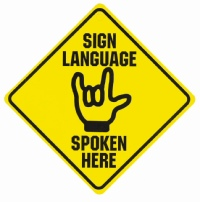

### 0. Imports, prep

In [2]:
!pip install imutils keras_cv_attention_models

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.8/635.8 kB 9.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.1 MB/s eta 0:00:00
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=5b0a2a3338d4ad401f0301ca6a0e89910c8e2e97a17bc42d661cc7ce0857970d
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatib

In [3]:
# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()
from dataclasses import dataclass

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.manifold import TSNE

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras_cv_attention_models import yolov8
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
@dataclass
class CFG():
    batch_size: int = 64
    img_height: int = 64
    img_width: int = 64
    epochs: int = 10
    num_classes: int = 29
    img_channels: int = 3
    seed: int = 69

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)
tf.random.set_seed(CFG.seed)

### 1. Dataset exploration, preprocessing

In [43]:
# Labels
TRAIN_PATH = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
TEST_PATH = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"
labels = []
letters = list(string.ascii_uppercase)
labels.extend(letters)
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [6]:
def plot_sample_imgs(labels, num_imgs=7):
    fig, axs = plt.subplots(len(labels), num_imgs + 1, figsize=(13, 12))
    
    for i, label in enumerate(labels):
        axs[i, 0].axis('off')
        axs[i, 0].text(0.5, 0.5, labels[i], va='center', ha='center')
        path_label = os.path.join(TRAIN_PATH, label)
        files = os.listdir(path_label)
        
        for j_imgs in range(1, num_imgs + 1):
            axs[i, j_imgs].axis('off')
            single_image_path = os.path.join(path_label, files[j_imgs])
            single_image = cv2.imread(single_image_path)
            single_image = cv2.cvtColor(single_image, cv2.COLOR_BGR2RGB)
            axs[i, j_imgs].imshow(single_image)
            

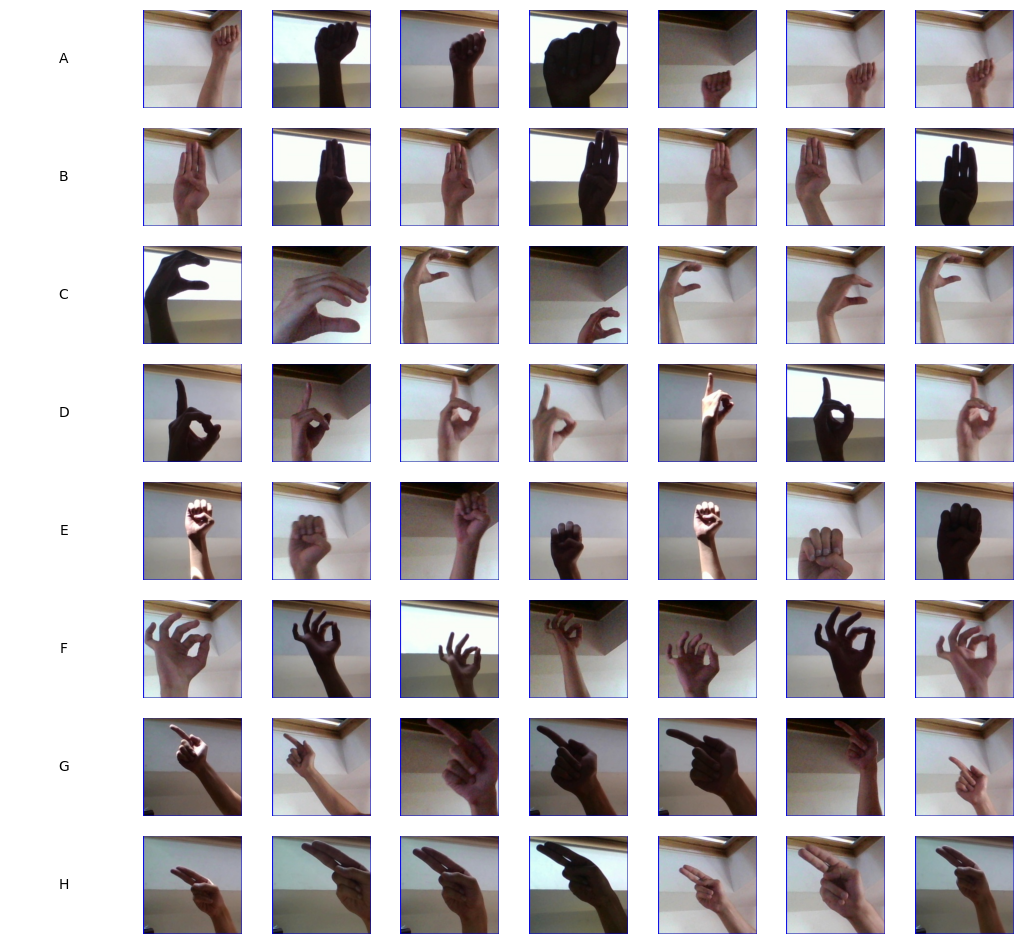

In [7]:
plot_sample_imgs(labels[:8])

Creating pd dataframe with file paths and target values:

In [8]:
image_paths = []
image_labels = []

for label in labels:
    image_path = os.path.join(TRAIN_PATH, label, '*')
    images_path = glob.glob(image_path)
    labels = [label] * len(images_path)
    image_paths += images_path
    image_labels += labels

data = pd.DataFrame({
    'path': image_paths,
    'label': image_labels
})   

data

path  label
0      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
1      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
2      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
3      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
4      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
...                                                  ...    ...
86995  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86996  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86997  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86998  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86999  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space

[87000 rows x 2 columns]

Train-val-test split (0.8 / 0.1 / 0.1)

In [9]:
test_size = val_size = 0.1
train_size = 0.8

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    data.path, data.label,
    test_size=test_size,
    random_state=CFG.seed,
    stratify=data.label,
    shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=val_size / (train_size + test_size),
    random_state=CFG.seed,
    stratify=y_train,
    shuffle=True
)
X_train.shape, X_val.shape, X_test.shape

((69600,), (8700,), (8700,))

In [29]:
data_train = pd.DataFrame({
    'path': X_train,
    'label': y_train
})
data_val = pd.DataFrame({
    'path': X_val,
    'label': y_val
})
data_test = pd.DataFrame({
    'path': X_test,
    'label': y_test
})

Rescaling images

In [12]:
def rescale():
    datagen = ImageDataGenerator(rescale=1/255)
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory='./',
        x_col='path',
        y_col='label',
        class_mode='categorical',
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=CFG.batch_size
    )
    val_generator = datagen.flow_from_dataframe(
        data_val,
        directory='./',
        x_col='path',
        y_col='label',
        class_mode='categorical',
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=CFG.batch_size
    )
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory='./',
        x_col='path',
        y_col='label',
        class_mode='categorical',
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=CFG.batch_size
    )
    
    return train_generator, val_generator, test_generator
    

In [13]:
train_generator, validation_generator, test_generator = rescale()

Found 69600 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


### 2. Building and training YoloV8 with custom classification layers

In [14]:
base = yolov8.YOLOV8_N_CLS(pretrained="imagenet", input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

11185072/11185072 [==============================] - 0s 0us/step
>>>> Load pretrained from: /root/.keras/models/yolov8_n_cls_imagenet.h5


In [15]:
base.layers[-2]

In [16]:
for layer in base.layers:
    layer.trainable = False

In [17]:
x = base.layers[-2].output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='leaky_relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='leaky_relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
preds = Dense(29, activation='softmax')(x)

model = Model(inputs=base.input, outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 stem_1_pad (ZeroPadding2D)     (None, 66, 66, 3)    0           ['input_1[0][0]']                
                                                                                                  
 stem_1_conv (Conv2D)           (None, 32, 32, 16)   432         ['stem_1_pad[0][0]']             
                                                                                                  
 stem_1_bn (BatchNormalization)  (None, 32, 32, 16)  64          ['stem_1_conv[0][0]']            
                                                                                              

In [18]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('asl_yolov8_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [19]:
history = model.fit(
    train_generator,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/10
1088/1088 [==============================] - 535s 484ms/step - loss: 1.2138 - accuracy: 0.6234 - val_loss: 0.4067 - val_accuracy: 0.8893
Epoch 2/10
1088/1088 [==============================] - 115s 105ms/step - loss: 0.7685 - accuracy: 0.7508 - val_loss: 0.3181 - val_accuracy: 0.9141
Epoch 3/10
1088/1088 [==============================] - 114s 104ms/step - loss: 0.6612 - accuracy: 0.7830 - val_loss: 0.2525 - val_accuracy: 0.9374
Epoch 4/10
1088/1088 [==============================] - 115s 106ms/step - loss: 0.6013 - accuracy: 0.8014 - val_loss: 0.2349 - val_accuracy: 0.9403
Epoch 5/10
1088/1088 [==============================] - 116s 107ms/step - loss: 0.5572 - accuracy: 0.8148 - val_loss: 0.2056 - val_accuracy: 0.9451
Epoch 6/10
1088/1088 [==============================] - 120s 110ms/step - loss: 0.5279 - accuracy: 0.8248 - val_loss: 0.1911 - val_accuracy: 0.9508
Epoch 7/10
1088/1088 [==============================] - 115s 106ms/step - loss: 0.5006 - accuracy: 0.8331 - val_

### 3. Model evaluation, metrics, visualising

In [54]:
accuracy = model.evaluate(test_generator)

136/136 [==============================] - 17s 123ms/step - loss: 0.1444 - accuracy: 0.9679


In [55]:
# Visualize Training and Validation Results

# Create Subplot
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["Model Loss", "Model Accuracy"], 
)

# Configuration Plot
class PlotCFG:
    marker_size = 8
    line_size = 2
    train_color = "#76503d"
    valid_color = "#deb392"

# Loss Plot
loss = history.history['loss']
val_loss = history.history['val_loss']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1), y=loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Loss"
    ), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1), y=val_loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Loss"
    ), row=1, col=1
)

# Accuracy Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(acc)+1), y=acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Accuracy"
    ), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_acc)+1), y=val_acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Accuracy"
    ), row=1, col=2
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)

# Update Layout
fig.update_layout(
    title="Training Loss and Metrics", title_x=0.5,
    width=950, height=400,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

In [56]:
preds = model.predict(test_generator)
preds

136/136 [==============================] - 13s 93ms/step


array([[1.87647137e-11, 2.90395420e-14, 1.02542289e-11, ...,
        1.86734898e-11, 9.99998450e-01, 8.94757868e-09],
       [8.14143863e-10, 3.32029124e-08, 2.86496197e-05, ...,
        5.89061703e-04, 3.64822696e-08, 1.20643153e-05],
       [8.96182701e-06, 2.93694757e-04, 9.98604119e-01, ...,
        8.75019236e-04, 2.73016121e-09, 1.84131821e-07],
       ...,
       [2.71956271e-08, 4.93111596e-09, 9.45971078e-06, ...,
        1.44955702e-04, 6.96362804e-06, 4.27410123e-04],
       [5.51662969e-12, 1.49370273e-12, 5.29818247e-12, ...,
        3.72707345e-13, 1.00000000e+00, 6.67020383e-10],
       [1.14019606e-07, 7.53037682e-07, 8.53928395e-06, ...,
        3.68186884e-05, 6.54276633e-09, 1.28853469e-06]], dtype=float32)

In [57]:
predictions = preds.argmax(axis=1)
predictions[:10]

array([27, 15,  2, 25, 19, 10, 12, 10,  2,  2])

In [58]:
def show_predictions(test_path):
    image_path = os.path.join(TEST_PATH, '*')
    imgs = sorted(glob.glob(image_path))

    columns = 7
    row = round(len(imgs) / columns)
    labs = (train_generator.class_indices)
    labs = dict((v,k) for k,v in labs.items())

    fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    i, j = 0, 0

    for img_path in imgs:
        origin_img = cv2.imread(str(img_path))
        origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
        label = img_path.split('/')[-1].split('_')[0]
        
        img = cv2.resize(origin_img, (CFG.img_height, CFG.img_width))
#         img = preprocess_input(img)

        prediction = model.predict(img[None]/255, verbose=0)
        
        ax[i][j].imshow(origin_img)
        ax[i][j].set_title(f'GT {label}. Pred {labs[np.argmax(prediction, axis=1)[0]]}')
        ax[i][j].axis('off')
        j += 1
        if j == columns:
            j = 0
            i += 1

    plt.show();

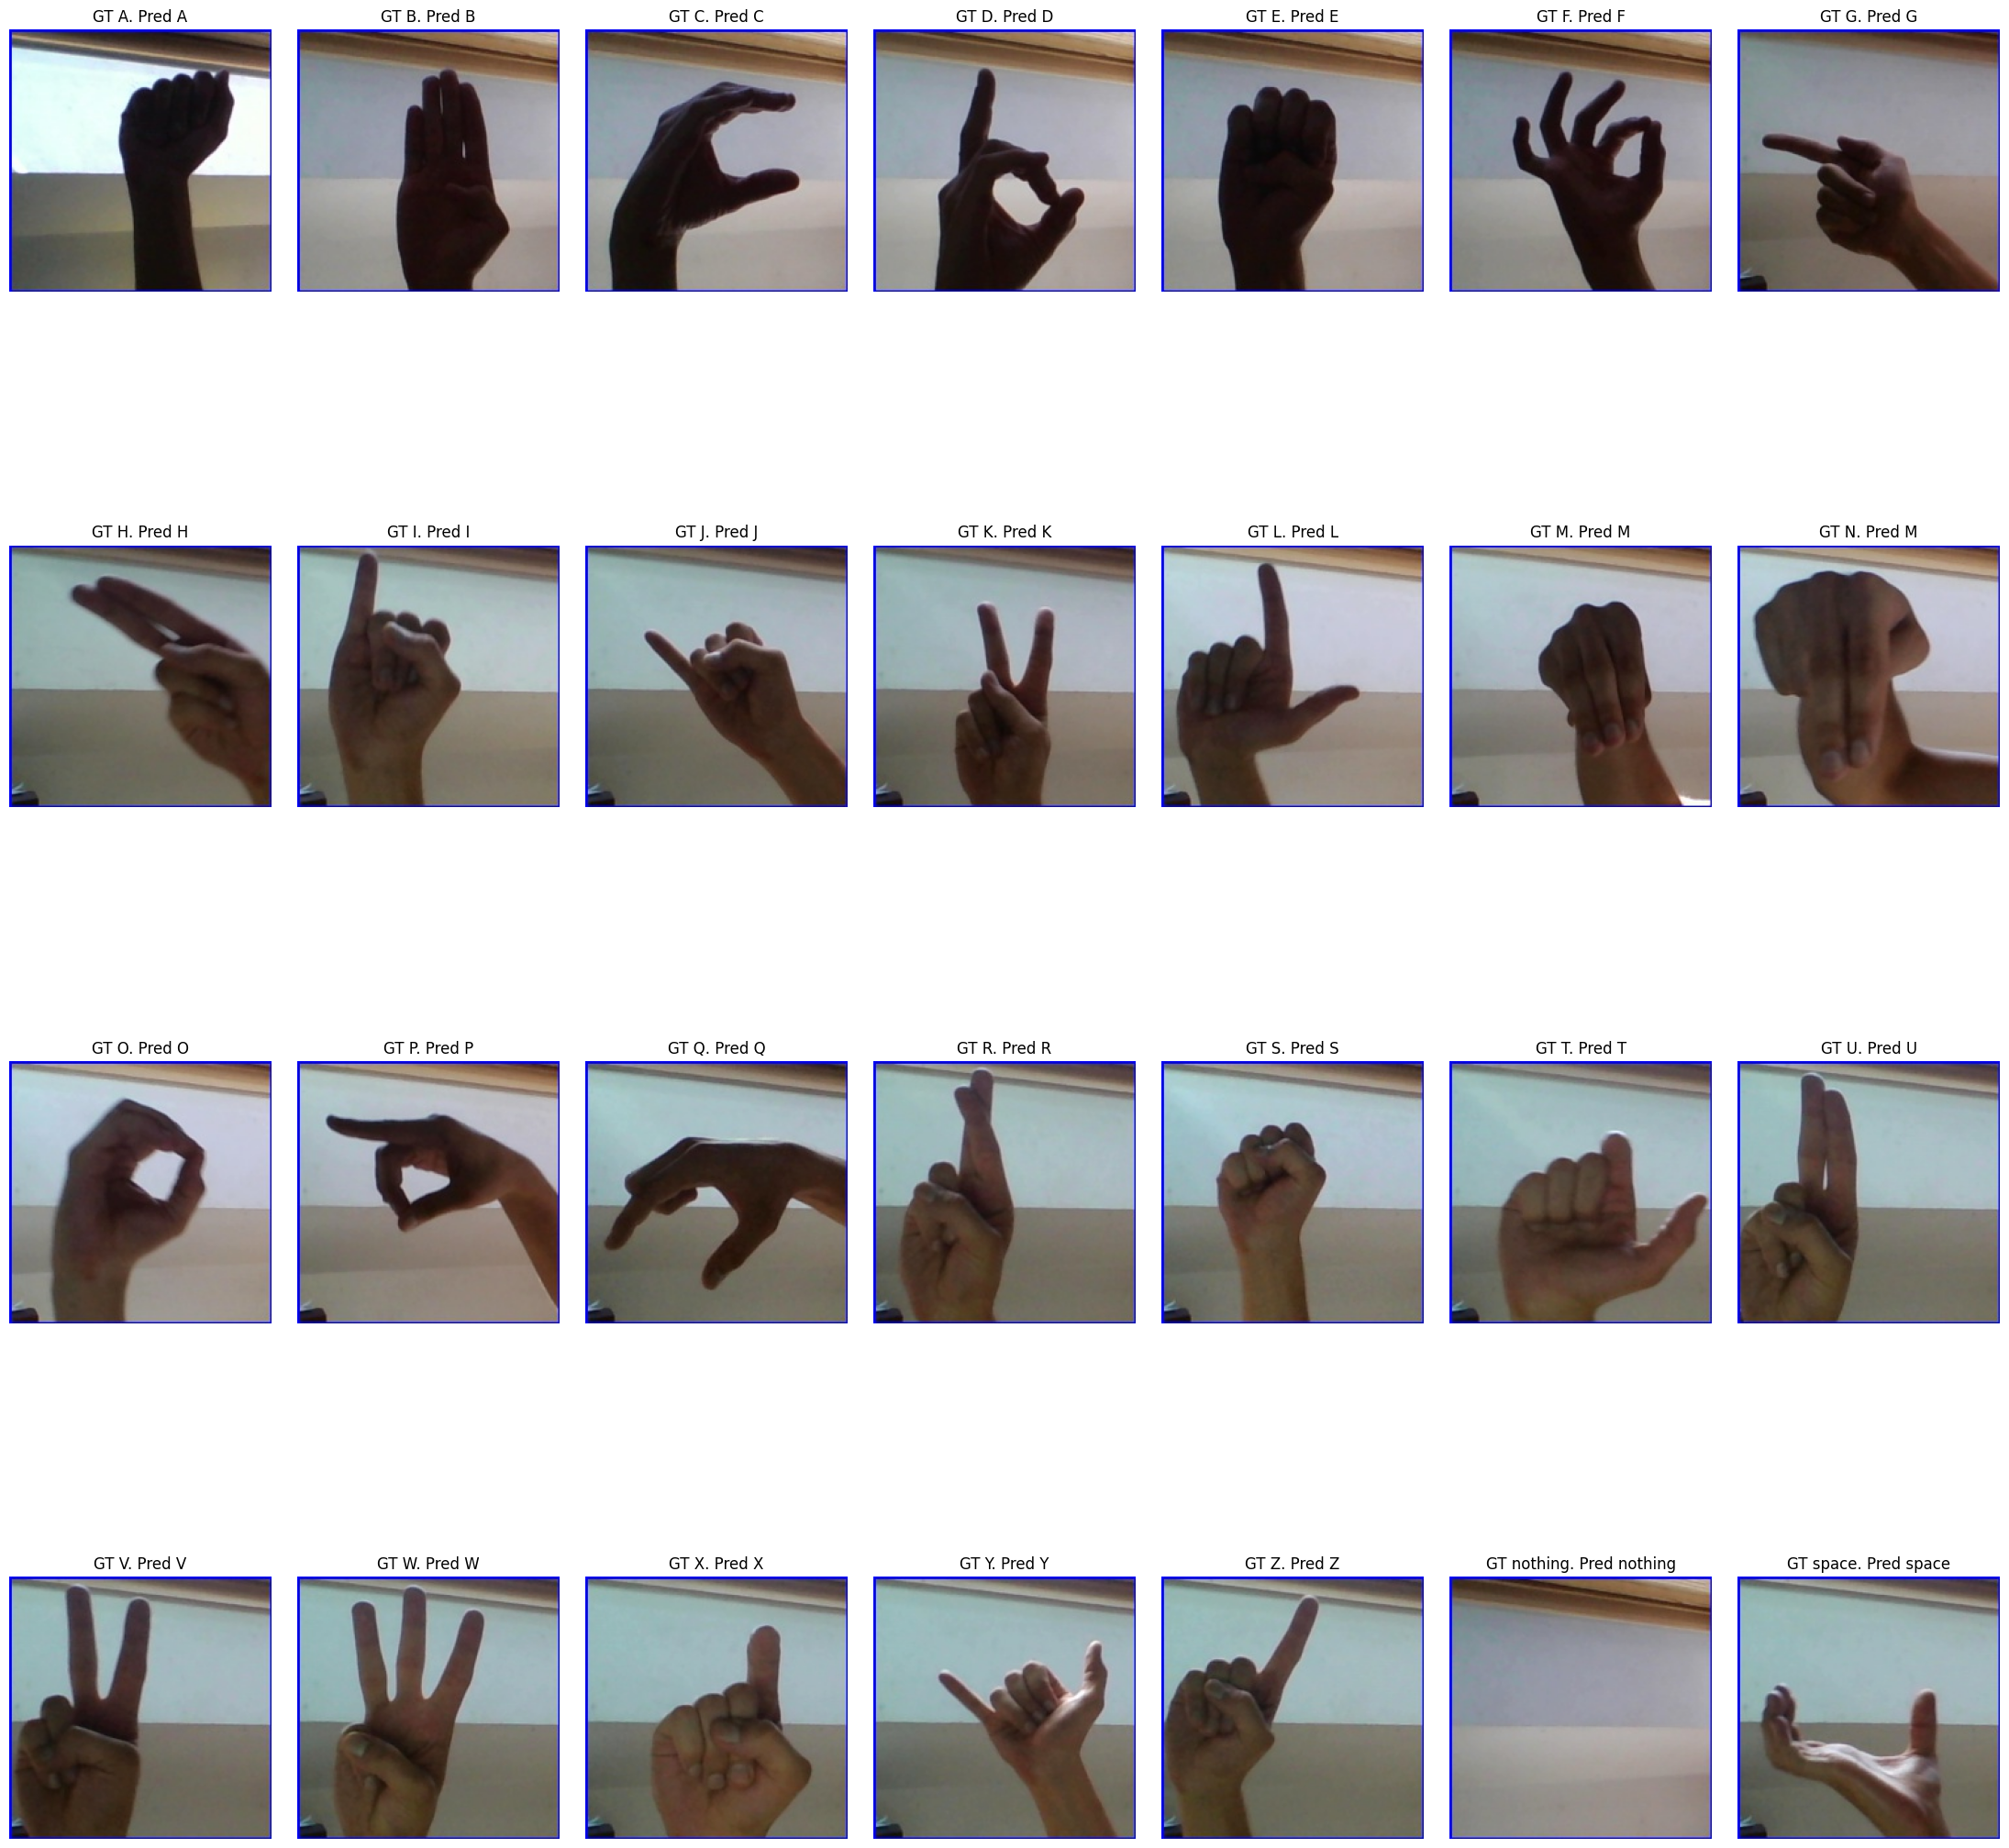

In [59]:
show_predictions(test_path=TEST_PATH)

### 4. Visualisation (TSNE)

I wanna look at latest (not including the output layer!) custom dense layer and try to make some predictions directly from it.

In [60]:
model.layers

In [61]:
dense_model = Model(inputs=model.inputs, outputs=model.layers[-4].output)
dense_model.summary()

Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 stem_1_pad (ZeroPadding2D)     (None, 66, 66, 3)    0           ['input_1[0][0]']                
                                                                                                  
 stem_1_conv (Conv2D)           (None, 32, 32, 16)   432         ['stem_1_pad[0][0]']             
                                                                                                  
 stem_1_bn (BatchNormalization)  (None, 32, 32, 16)  64          ['stem_1_conv[0][0]']            
                                                                                           

In [62]:
# Extract Features in Dense Layer
def dense_feature_prediction(img_path):
    img = load_img(img_path, target_size=(CFG.img_height, CFG.img_width))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    dense_feature = dense_model.predict(img, verbose=0)[0]
    return dense_feature

reduction_data = pd.DataFrame()
for label in labels:
    label_data = data_test[data_test['label']==label][:100]
    reduction_data = reduction_data.append(label_data)

reduction_data = reduction_data.reset_index(drop=True)

dense_features = reduction_data['path'].progress_apply(dense_feature_prediction)
dense_features = pd.DataFrame.from_records(dense_features.values, index=dense_features.index)
dense_features

100%|██████████| 2900/2900 [03:39<00:00, 13.19it/s]


0          1          2         3         4          5         6    \
0    -0.827689  -1.597091  -0.018318 -0.900618  7.500199  -2.239650 -1.117241   
1     1.949447  -1.241278   5.224761 -1.825099 -0.597978  -0.914785  0.426648   
2    -0.555638  -1.619548  24.650463 -2.530259 -0.034568  -4.298070  5.201882   
3    -0.340402  -3.350214   4.707465 -0.555601 -0.234783  -2.796146 -1.277202   
4    -0.924098  -0.085063   8.445166 -2.112356  0.712938  -2.645389  4.262668   
...        ...        ...        ...       ...       ...        ...       ...   
2895  3.582569   1.033852  -2.330918 -1.341240 -0.715111   6.954278 -2.103732   
2896  8.780546  11.002267  -1.410667  0.304860 -0.070219  14.370486 -2.390792   
2897  8.918000  10.457016  -3.582011  1.006779  1.268445  15.600077 -0.915592   
2898  5.229101   7.415650  -1.335786  3.025088 -0.051101  10.996142 -1.078736   
2899  8.292163   8.695114  -1.621792  5.271816 -0.230789  12.026836 -0.987325   

            7          8         9    ...        502       503        504  \
0     -1.120468   2.361459 -1.228371  ...   1.259127 -2.075922  -2.143905   
1     -0.317198  -1.483577  3.414961  ...   1.238246 -0.828553  -0.339419   
2      5.724109  -0.804481 -1.220803  ...  -1.578673 -1.533947  -3.477612   
3     -0.895131  -0.522799 -0.791346  ...   0.392093 -2.064363  -3.522492   
4     -0.057610  -0.455148 -0.258738  ...  -0.031484 -0.760192  -2.301560   
...         ...        ...       ...  ...        ...       ...        ...   
2895  10.302043  23.863272 -0.835508  ...  15.500206 -0.698878  15.194721   
2896  -1.714281  16.255239 -0.168748  ...   0.675938 -0.770940  17.269735   
2897   2.227806  12.931110  0.157765  ...   3.417346 -0.334674  10.433642   
2898   2.892317   4.787477 -1.008801  ...  -0.439345 -0.372505  12.939235   
2899   2.076661   7.887086 -1.102075  ...  -0.392973 -0.563011  12.455310   

            505        506        507        508       509       510  \
0     -2.578680  -0.892241   5.174994  -1.440923 -1.460966  2.059640   
1     -0.783388  -0.293878  -1.585982  -0.216552  0.100118 -0.681172   
2     -4.948488   2.982080  -1.446745  -1.893105  9.012028 -1.925750   
3     -3.387391   2.693469   7.586768  -1.559340 -2.058437  3.987251   
4     -2.328208  -0.394814   0.528865  -1.112291  4.757115 -0.468765   
...         ...        ...        ...        ...       ...       ...   
2895   9.208283  -0.583298   6.372908   5.787386 -3.499909 -3.469856   
2896  14.884723  10.020590  13.004873  20.248386 -2.948337 -2.304659   
2897  17.599905   3.148201  12.429719  12.120026 -1.545916 -2.438730   
2898  12.952386   6.037407   2.315081  12.191405 -0.580863 -1.401653   
2899  11.820939   7.918463   1.584713  14.704000 -1.049909 -1.760153   

            511  
0      6.725483  
1      1.025460  
2     23.908455  
3     14.732658  
4     10.443586  
...         ...  
2895   1.653882  
2896   1.906765  
2897   3.955998  
2898  -1.047959  
2899  -1.125831  

[2900 rows x 512 columns]

In [63]:
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_features = tsne.fit_transform(dense_features)
tsne_features = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features
reduction_data

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2900 samples in 0.004s...
[t-SNE] Computed neighbors for 2900 samples in 0.366s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2900
[t-SNE] Computed conditional probabilities for sample 2000 / 2900
[t-SNE] Computed conditional probabilities for sample 2900 / 2900
[t-SNE] Mean sigma: 36.578286
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.604324
[t-SNE] KL divergence after 1000 iterations: 0.884537


path  label  tsne_feat_0  \
0     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A     0.134356   
1     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A     3.518299   
2     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A    -7.502841   
3     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A    -0.686885   
4     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A    -6.766217   
...                                                 ...    ...          ...   
2895  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space     8.355076   
2896  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space     7.274045   
2897  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space     8.536359   
2898  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space     8.935007   
2899  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space     8.911456   

      tsne_feat_1  
0      -29.006006  
1       -2.806111  
2      -21.461081  
3      -28.381260  
4      -24.302229  
...           ...  
2895    23.584488  
2896    17.329947  
2897    16.447214  
2898    19.139591  
2899    19.337234  

[2900 rows x 4 columns]

In [64]:
# Scatter Plot
list_colors = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FF4500", "#800080", "#32CD32", "#8B0000", 
               "#000080", "#808000", "#FF6347", "#008080", "#FF1493", "#7FFF00", "#D2691E", "#9400D3", "#B22222", "#ADFF2F",
               "#ADD8E6", "#FF69B4", "#F0E68C", "#4682B4", "#9ACD32", "#800000", "#FFD700", "#20B2AA", "#A52A2A"
              ]
fig = px.scatter(
    reduction_data, x="tsne_feat_0", y="tsne_feat_1", color='label', color_discrete_sequence=list_colors
)

fig.update_traces(marker=dict(size=8),)

# Update Axes
fig.update_xaxes(title="", linecolor="Black", zeroline=False, mirror=True)
fig.update_yaxes(title="", linecolor="Black", zeroline=False, mirror=True)

# Update Layout
fig.update_layout(
    title_text="t-SNE Visualization", title_x=0.5,
    width=900, height=900,
    plot_bgcolor='White',
    coloraxis_showscale=False,
)

# Show
fig.show()

### 5. Class Activation Maps (Grad-CAM)

reference: https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/

In [65]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
            
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])
        
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        
        # return the resulting heatmap to the calling function
        return heatmap
    
    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [66]:
def gradcam_images(labels):
    # Create Subplots
    fig, axs = plt.subplots(len(labels), 7, figsize=(12, 10))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')
        
        label_data = data_test[data_test['label']==label][:2].reset_index(drop=True)

        for j in range(2):
            # Read Original Image
            orig = cv2.imread(label_data['path'][j])
            orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
            
            # Preprocess and Predict Label from Image
            img = load_img(label_data['path'][j], target_size=(CFG.img_height, CFG.img_width))
            img = img_to_array(img) / 255.
            img = np.expand_dims(img, axis=0)
            img_label_ci = model.predict(img, verbose=0)
            img_label = np.argmax(img_label_ci[0])
            
            # Compute Heatmap using GradCAM
            cam = GradCAM(model, img_label)
            heatmap = cam.compute_heatmap(img)
            
            # Overlay Heatmap with Original Image
            heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
            
            # Show Original, Heatmap, and Overlap Heatmap Images
            axs[i, j*3+1].imshow(orig)
            axs[i, j*3+1].axis("off")
            axs[i, j*3+2].imshow(heatmap)
            axs[i, j*3+2].axis("off")
            axs[i, j*3+3].imshow(output)
            axs[i, j*3+3].axis("off")

    # Title
    plt.suptitle("Class Activation Maps (GradCAM) in Test Images", x=0.5, y=1)

    # Show
    plt.show()

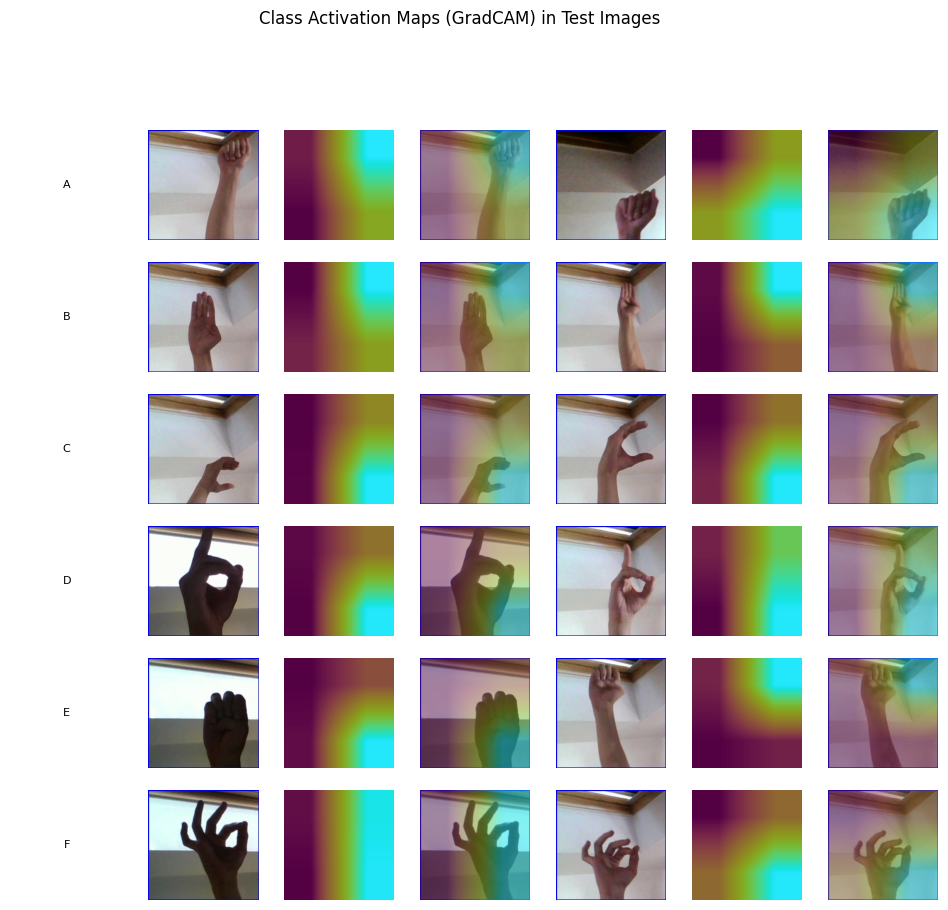

In [67]:
gradcam_images(labels[:6])